In [1]:
%reset
import numpy as np
from numpy.linalg import norm, inv
import time
import math
from correct_final_code_feb24 import *
from tensorflow import keras
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


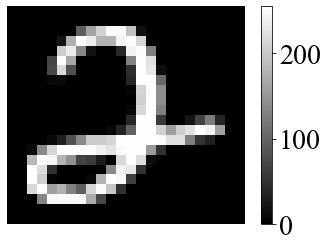

In [6]:
# result 1
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")
sample = 16
image = x_train[sample]
image = image[3:25, 4:28]
plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.colorbar()
plt.rcParams.update({'font.size': 28})

plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('result_all_correct_Mar11/original_image_Mar25.pdf', bbox_inches='tight')
plt.show()

In [7]:
gamma_e = np.log(2)/4/np.pi # in the unit of Omega
gamma_e_t_R = gamma_e*2*np.pi

In [8]:
kernel_given = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
in_dim = image.shape[1] + 2
kernel_arr_neg, kernel_arr_pos, kernel_0 = kernel_to_array_0217(in_dim, 
                                                                kernel_given)

kernel_arr_neg

array([-2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
       -1.])

In [9]:
dim = (in_dim)*(image.shape[0]+2)
kernel_big_mat = populate_matrix_posNeg(dim, kernel_arr_neg, kernel_arr_pos, kernel_0)

YDim = dim
YposVec, YnegVec, Y0 = inv_trans_matrix_0718(kernel_arr_pos, kernel_arr_neg, 
                                             kernel_0, YDim)

In [10]:
Ybuilt = populate_matrix_posNeg(dim, YnegVec[:dim], YposVec[:dim], Y0)
result = Ybuilt.dot(kernel_big_mat)
dim_cut = 30
checked = result[dim_cut:dim-dim_cut,dim_cut:dim-dim_cut]
print(np.max(abs(checked - np.identity(checked.shape[0]))))
# so the inverse is correct
# plt.imshow(checked.real)

2.5000138329935357e-05


In [11]:
# without angle 
t_list = np.linspace(0, 2*np.pi, num=1000, endpoint=True)

result_list = np.zeros(t_list.shape)

# for all the t find the max of this
index_list = np.arange(0, kernel_arr_neg.shape[0],1)+1
for ii, t in enumerate(t_list):
    
    result_list[ii] = abs(kernel_0 + sum(kernel_arr_neg*np.exp(-1j*index_list*t))+sum(kernel_arr_pos*np.exp(1j*index_list*t)))
norm_fac = max(result_list*1.1)
    
    
    
print(norm_fac)
kappa_pos, kappa_neg, kappa0 = from_S_get_kappa_0718(kernel_arr_pos, kernel_arr_neg, 
                                                     kernel_0, norm_fac, YDim)
# kappa is in the unit of gamma_e

8.735494855436206


In [12]:
A_list, B_list, gamma0 = find_modulate_AmpPha_0718_without_angle(kappa_pos,
                                                                 kappa_neg, kappa0)

alpha_list = np.pi/2*np.ones_like(A_list)
beta_list = np.pi/2*np.ones_like(A_list)

kappa_posBuild, kappa_negBuild, kappa0Build = forward_build_Xvec_0718_without_angle(A_list,
                                                                                    B_list,
                                                                                    gamma0)

norm_fac_from_now = 1

kernel_arr_posBuild, kernel_arr_negBuild, kernel_0Build = from_kappa_get_S_0718(kappa_posBuild,
                                                                                kappa_negBuild, 
                                                                                kappa0Build, 
                                                                                norm_fac_from_now, dim)

kernel_big_built = populate_matrix_posNeg(dim, kernel_arr_negBuild, 
                                          kernel_arr_posBuild, kernel_0Build)

In [13]:
print(gamma0*gamma_e)

(0.04293671944269656-2.3270225540232176e-09j)


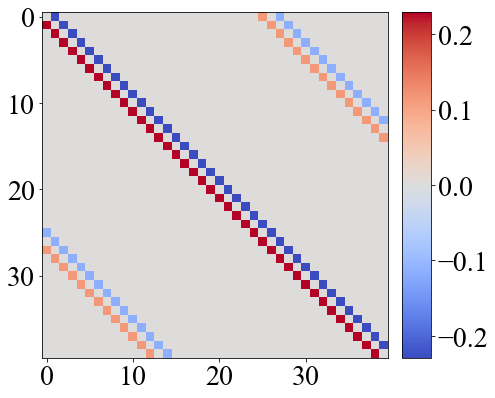

In [14]:
def plot_matrix(mat, figsize, cmap=plt.cm.coolwarm):
    f = plt.figure(figsize=figsize)
    ax = plt.axes([0.05, 0.05, 0.65, 0.6]) #left, bottom, width, height
    #note that we are forcing width:height=1:1 here, 
    #as 0.9*8 : 0.9*8 = 1:1, the figure size is (8,8)
    #if the figure size changes, the width:height ratio here also need to be changed
    im = ax.imshow(mat, interpolation='nearest', cmap=cmap, vmin = -np.max(mat), vmax = np.max(mat))
#     vmin = -4, vmax = +4
    ax.grid(False)
    cax = plt.axes([0.7, 0.05, 0.05, 0.6])
    plt.colorbar(mappable=im, cax=cax)
    return ax, cax
# result 4
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rcParams['font.family'] = 'Times New Roman'
data = np.real(kernel_big_built[:40, :40])
ax, cax = plot_matrix(data, (8,8)) 

# 0 1 0

plt.savefig('result_all_correct_Mar11/Figure4_kernel_matrix_built_Ix_Mar25.pdf', bbox_inches='tight')

In [15]:
def passivity_metric(gamma0, B_list, beta_list):
    t_list = np.arange(0, 2*np.pi, 0.01)
    result_list = np.zeros(t_list.shape, dtype = complex)
    
    # for all the t find the max of this
    index_list = np.arange(0, len(B_list),1)+1
    for ii, t in enumerate(t_list):
        result_list[ii] = sum(B_list*np.sin(index_list*t + beta_list))
    constraint = max(result_list)
    return gamma0 > constraint


print(passivity_metric(gamma0, (B_list[:dim]), beta_list[:dim]))
# norm_fac

True


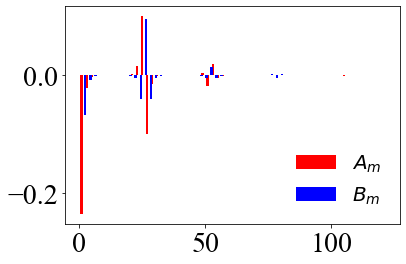

In [29]:
fig, axs = plt.subplots()
ax0 = axs
# result 2
cut_site = 120
plt.bar(np.arange(0, len(A_list[:cut_site]),1)+1, A_list[:cut_site]*gamma_e_t_R, fc = 'r', width = 1, label = '$A_m$')
plt.bar(np.arange(0, len(A_list[:cut_site]),1)+1 + 0.5, B_list[:cut_site]*gamma_e_t_R, fc = 'b',  width = 1, label = '$B_m$')
# plt.plot(np.arange(0, len(A_list[:cut_site]),1)+1, A_list[:cut_site]*gamma_e_t_R, color='red', linewidth=2)

# plt.legend(prop={'size': 20})
plt.legend(frameon=False, loc='lower right',prop={'size': 20})

plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rcParams['font.family'] = 'Times New Roman'
# ax0.set_yticks([0, -0.5, 0.5, 1])
# ax0.set_xticks([1, 26, 52])
# plt.ylim([-0.8, 1])
plt.savefig('result_all_correct_Mar11/Figure4_Amplitude_right_Ix_Mar25.pdf', bbox_inches='tight')
plt.show()

In [17]:

def givenKerBig_conv_results_Nov18(image, kernel_big_mat_final):
    # kernel_given

    # this is given the kernel
    # how you pad
    input_image = np.pad(image,((1, 1), (1, 1)),'constant')
    img_arr = input_image.flatten()
#     dim = input_image.shape[0]*input_image.shape[1]
#     kernel_big_mat_final = populate_matrix_posNeg_Nov17(dim, kernel_arr_neg, 
#                                                         kernel_arr_pos, kernel_0)
    mat_ops_arr_final = kernel_big_mat_final.dot(img_arr)

    mat_output = mat_ops_arr_final.reshape(-1, input_image.shape[1])
    mat_output = mat_output[1:-1,1:-1]
    return mat_output, mat_ops_arr_final


In [18]:
output_generate_image,_ = givenKerBig_conv_results_Nov18(image, kernel_big_built)

print(np.max(abs(kernel_big_built - kernel_big_mat)))

1.7710490362608182


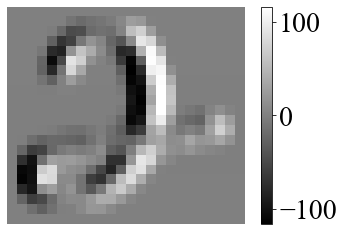

In [19]:
plt.imshow(output_generate_image.real, cmap = 'gray')
plt.axis('off')
plt.colorbar()
plt.savefig('result_all_correct_Mar11/Figure4_generate_image_Ix_Mar25.pdf', bbox_inches='tight')
plt.show()
#

In [20]:
# modulation
t_list = np.linspace(0, 2*np.pi, num=1000, endpoint=True)
amplitude_list = np.zeros(t_list.shape)
phase_list = np.zeros(t_list.shape)

# for all the t find the max of this
index_list = np.arange(0, len(B_list[:220]),1)+1
for ii, t in enumerate(t_list):
    
    amplitude_list[ii] = sum(B_list[:220]*gamma_e_t_R*np.sin(index_list*t + beta_list[:220]))-gamma0*gamma_e_t_R
    phase_list[ii] = sum(A_list[:220]*gamma_e_t_R*np.cos(index_list*t + alpha_list[:220]))


<ipython-input-20-8bedc667daa8>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  amplitude_list[ii] = sum(B_list[:220]*gamma_e_t_R*np.sin(index_list*t + beta_list[:220]))-gamma0*gamma_e_t_R


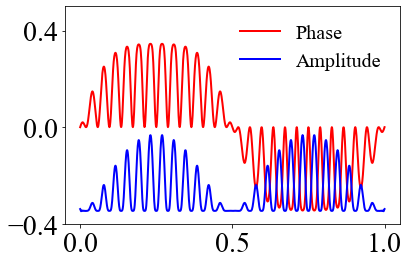

In [31]:
fig, axs = plt.subplots()
ax0 = axs

plt.plot(t_list/(2*np.pi), phase_list,'r',linewidth=2.0, label = 'Phase')
plt.plot(t_list/2/np.pi, amplitude_list, 'b',linewidth=2.0, label = 'Amplitude')

plt.legend(frameon=False, loc='upper right', prop={'size': 20})
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rcParams['font.family'] = 'Times New Roman'
ax0.set_yticks([0, -0.4, 0.4])
plt.ylim([-0.4, 0.5])
# ax0.set_xticks([0, np.pi, np.pi*2])
plt.savefig('result_all_correct_Mar11/Figure4_modulated_form_Ix_Mar25.pdf', bbox_inches='tight')
plt.show()